In [2]:
!pip3 install resampy
!pip3 install librosa
!pip3 install joblib
!pip3 install tensorflow
!pip3 install keras


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.13 -m pip install --upgrade pip
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this erro

In [3]:
import os
import shutil
import subprocess
import tempfile
import pandas as pd
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

LOAD_MODEL = True # Whether to train the model, or just evaluate based on 21Jan2025.h5

AUDIO_CONTENT_DIR = 'content/audio'       # Original audio directory
FEATURES_CONTENT_DIR = 'content/features' # Pre-calculated features (MFCCs)
classes = ["human", "ai"]

SEGMENT_DURATION = 1.0  # Duration of each audio segment in seconds
HOP_LENGTH = 1.0        # Hop length in seconds between segments (should usually be the same as segment duration)
PAD_LEN = 40           # Fixed length for MFCC padding/truncating
MFCC_COUNT = 40        # Number of MFCCs per set (set this according to segment duration)

# Volume is randomized during normalization between these two values
MAX_TARGET_DB = -20 
MIN_TARGET_DB = -40 

# Utils
def db_to_linear(db):
    return 10 ** (db / 20)
def linear_to_db(rms):
    return 20 * np.log10(rms) if rms > 0 else -np.inf

In [4]:
# Define the chop_audio Function
def chop_audio(audio, sample_rate=22050, segment_duration=SEGMENT_DURATION, hop_length=HOP_LENGTH):
    """
    Splits an audio array into multiple segments.

    Parameters:
    - audio (np.ndarray): The original audio signal.
    - sample_rate (int): The sample rate of the audio.
    - segment_duration (float): Duration of each segment in seconds.
    - hop_duration (float): Time to skip between segments in seconds.

    Returns:
    - List[np.ndarray]: List of audio segments.
    """
    segment_length_samples = int(segment_duration * sample_rate)
    hop_length_samples = int(hop_length * sample_rate)
    segments = []

    for start in range(0, len(audio) - segment_length_samples + 1, hop_length_samples):
        end = start + segment_length_samples
        segment = audio[start:end]
        segments.append(segment)

    return segments

In [5]:
def extract_features(audio, sample_rate=22050, pad_len=PAD_LEN):
    """
    Extracts MFCC features from an audio segment and pads/truncates them to a fixed length.
    
    Parameters:
    - audio (np.ndarray): The audio segment.
    - sample_rate (int): The sample rate of the audio.
    - pad_len (int): The fixed length for padding/truncating.
    
    Returns:
    - np.ndarray: MFCC feature array of shape (40, PAD_LEN).
    """
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Calculate padding or truncating
        pad_width = pad_len - mfccs.shape[1]
        
        if pad_width > 0:
            # Pad MFCCs with zeros on the right
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate MFCCs to the desired length
            mfccs = mfccs[:, :pad_len]
        
        return mfccs
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return None


In [6]:
def normalize_loudness(audio, max_db=MAX_TARGET_DB, min_db=MIN_TARGET_DB, debug=False):
    """
    Normalizes the loudness of an audio segment to a random target RMS between min_db and max_db,
    ensuring that no clipping occurs. Logs the difference from the original dB if clipping is prevented.
    
    Parameters:
    - audio (np.ndarray): The audio segment.
    - max_db (float): Maximum target RMS in decibels.
    - min_db (float): Minimum target RMS in decibels.
    
    Returns:
    - np.ndarray: The normalized audio segment.
    """
    target_db = random.uniform(min_db, max_db)
    target_rms = db_to_linear(target_db)
    
    current_rms = np.sqrt(np.mean(audio**2))
    if current_rms == 0:
        return audio  # Avoid division by zero
    
    desired_scaling = target_rms / current_rms
    max_sample = np.max(np.abs(audio * desired_scaling))
    
    if max_sample > 1.0:
        # Calculate scaling factor to prevent clipping
        clipping_scaling = 1.0 / np.max(np.abs(audio))
        # Choose the smaller scaling factor
        scaling_factor = min(desired_scaling, clipping_scaling)
        adjusted_rms = current_rms * scaling_factor
        adjusted_db = linear_to_db(adjusted_rms)
        db_difference = adjusted_db - target_db
        if debug:
            print(f"Clipping prevented: Original target_db={target_db:.2f} dB, "
              f"Adjusted target_db={adjusted_db:.2f} dB, Difference={db_difference:.2f} dB")
    else:
        scaling_factor = desired_scaling
    
    normalized_audio = audio * scaling_factor
    return normalized_audio


In [7]:
def process_and_save_npy(file_path, label, output_dir, augment=True, force=False):
    """
    Processes a single audio file: extracts MFCC features and saves them as a compressed .npz file.
    
    Parameters:
    - file_path (str): Path to the audio file.
    - label (int): Label of the audio file (0 for human, 1 for ai).
    - output_dir (str): Directory to save the .npz feature file.
    - augment (bool): If True, apply loudness normalization. If False, skip normalization.
    - force (bool): If True, overwrite existing feature files.
    
    Returns:
    - None
    """
    try:
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        output_file = os.path.join(output_dir, f"{base_name}.npz")
        
        # Check if feature file is already saved. Does not perform additional checks like if the feature file matches the CURRENT segment length.
        if os.path.exists(output_file) and not force:
            print(f"Features for '{base_name}' already exist. Skipping.")
            return
        
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', mono=True)
        
        # Chop the audio into segments
        segments = chop_audio(audio, sample_rate, SEGMENT_DURATION, HOP_LENGTH)
        
        # Extract features for each segment
        features = []
        for segment in segments:
            if augment:
                normalized_segment = normalize_loudness(segment, MAX_TARGET_DB, MIN_TARGET_DB)
            else:
                normalized_segment = segment  # Skip normalization for validation
            mfcc = extract_features(normalized_segment, sample_rate, PAD_LEN)
            if mfcc is not None:
                features.append(mfcc.astype(np.float32))  # Ensure float32 for consistency
        
        if not features:
            print(f"No features extracted for '{base_name}'. Skipping saving.")
            return
        
        # Convert to numpy array and add channel dimension
        features = np.array(features, dtype=np.float32)[..., np.newaxis]  # Shape: (num_segments, 40, PAD_LEN, 1)
        
        # Save as compressed .npz file
        np.savez_compressed(output_file, features=features, label=label)
        print(f"Saved features for '{base_name}' to '{output_file}'")
    
    except Exception as e:
        print(f"Error processing '{file_path}': {e}")

In [8]:
def load_features(feature_dir, classes):
    """
    Loads precomputed features from training and validation directories and maps them to file names.
    
    Parameters:
    - feature_dir (str): Path to the features directory.
    - classes (list): List of class names (e.g., ["human", "ai"]).
    
    Returns:
    - features_mapping (dict): Dictionary mapping file names (without extension) to their features and labels.
    """
    features_mapping = {}
    splits = ['train', 'validation']
    
    for split in splits:
        for cls in classes:
            subdir_path = os.path.join(feature_dir, split, cls)
            if not os.path.isdir(subdir_path):
                print(f"Directory '{subdir_path}' does not exist. Skipping.")
                continue
            
            label = classes.index(cls)  # 0 for human, 1 for ai
            
            for file in os.listdir(subdir_path):
                if file.lower().endswith('.npz'):
                    base_name = os.path.splitext(file)[0]
                    if base_name in features_mapping:
                        print(f"Features for '{base_name}' already loaded. Skipping.")
                        continue
                    
                    file_path = os.path.join(subdir_path, file)
                    try:
                        with np.load(file_path) as data:
                            features = data['features']
                            label = int(data['label'])
                            features_mapping[base_name] = {
                                'features': features,  # Shape: (num_segments, 40, PAD_LEN, 1)
                                'label': label         # 0 for human, 1 for ai
                            }
                    except Exception as e:
                        print(f"Error loading '{file_path}': {e}")
    
    print(f"Total feature files loaded: {len(features_mapping)}")
    return features_mapping

In [9]:
def save_all_features(force=False):
    """
    Processes and saves features from both training and validation directories.
    
    Parameters:
    - force (bool): If True, overwrite existing feature files.
    
    Returns:
    - train_files (list): List of training file names (without extension).
    - val_files (list): List of validation file names (without extension).
    """
    classes = ["human", "ai"]
    
    # Define splits; used to determine file paths
    splits = {
        'train': True,        # Apply augmentation
        'validation': False   # Do not apply augmentation
    }
    
    train_files = []
    val_files = []
    
    for split, augment in splits.items():
        for cls in classes:
            cls_audio_dir = os.path.join(AUDIO_CONTENT_DIR, split, cls)
            cls_feature_dir = os.path.join(FEATURES_CONTENT_DIR, split, cls)
            for f in os.listdir(cls_audio_dir):
                if f.lower().endswith(('.wav', '.mp3')):
                    file_path = os.path.join(cls_audio_dir, f)
                    label = classes.index(cls)
                    process_and_save_npy(file_path, label, cls_feature_dir, augment=augment, force=force)
                    
                    base_name = os.path.splitext(f)[0]
                    if split == 'train':
                        train_files.append(base_name)
                    else:
                        val_files.append(base_name)
                    
    print("Feature extraction and saving complete.")
    print(f"Training files: {len(train_files)}")
    print(f"Validation files: {len(val_files)}")
    
    return train_files, val_files

In [10]:
def verify_class_distribution(y, dataset_type='Dataset'):
    class_labels = np.argmax(y, axis=1)
    unique, counts = np.unique(class_labels, return_counts=True)
    class_distribution = dict(zip(['human', 'ai'], counts))
    print(f"{dataset_type} class distribution: {class_distribution}")

In [11]:
def verify_directory_structure(feature_dir, audio_dir, classes=["human", "ai"], splits=["train", "validation"]):
    """
    Verifies the directory structure and ensures that the number of feature files matches the number of audio files.
    Prints details including the effective split percentages between train and validation for each class.
    
    Parameters:
    - feature_dir (str): Path to the base features directory (e.g., 'content/features').
    - audio_dir (str): Path to the base audio directory (e.g., 'content/audio').
    - classes (list): List of class names (e.g., ["human", "ai"]).
    - splits (list): List of data splits (e.g., ["train", "validation"]).
    
    Returns:
    - None
    """
    print(f"Verifying directory structure between '{audio_dir}' and '{feature_dir}'...\n")
    
    counts = {cls: {split: {"audio": 0, "features": 0} for split in splits} for cls in classes}
    total_counts = {cls: {"audio": 0, "features": 0} for cls in classes}
    
    # Flag to track overall structure validity
    structure_valid = True
    
    for split in splits:
        for cls in classes:
            audio_split_dir = os.path.join(audio_dir, split, cls)
            feature_split_dir = os.path.join(feature_dir, split, cls)
            
            # Check if directories exist
            if not os.path.isdir(audio_split_dir):
                print(f"Missing audio directory: '{audio_split_dir}'")
                structure_valid = False
            if not os.path.isdir(feature_split_dir):
                print(f"Missing feature directory: '{feature_split_dir}'")
                structure_valid = False
                continue  # Skip counting if feature directory doesn't exist
            
            # Count audio files
            audio_files = [f for f in os.listdir(audio_split_dir) if f.lower().endswith(('.wav', '.mp3'))]
            audio_count = len(audio_files)
            counts[cls][split]["audio"] = audio_count
            total_counts[cls]["audio"] += audio_count
            
            # Count feature files
            feature_files = [f for f in os.listdir(feature_split_dir) if f.lower().endswith('.npz')]
            feature_count = len(feature_files)
            counts[cls][split]["features"] = feature_count
            total_counts[cls]["features"] += feature_count
            
            # Print counts
            print(f"Class '{cls}' - Split '{split}':")
            print(f"  Audio files: {audio_count}")
            print(f"  Feature files: {feature_count}\n")
            
            # Check if counts match
            if audio_count != feature_count:
                print(f"Mismatch in counts for Class '{cls}', Split '{split}':")
                print(f"  Audio files: {audio_count} vs Feature files: {feature_count}\n")
                structure_valid = False
    
    if not structure_valid:
        print("Directory structure verification failed due to missing directories or mismatched file counts.\n")
    else:
        print("All directories exist and file counts match.\n")
    
    print("Effective Split Percentages:\n")
    for cls in classes:
        train_audio = counts[cls]["train"]["audio"]
        val_audio = counts[cls]["validation"]["audio"]
        total_audio = total_counts[cls]["audio"]
        
        if total_audio == 0:
            print(f"Class '{cls}': No audio files found.")
            continue
        
        train_pct = (train_audio / total_audio) * 100
        val_pct = (val_audio / total_audio) * 100
        
        print(f"Class '{cls}':")
        print(f"  Training: {train_audio} files ({train_pct:.2f}%)")
        print(f"  Validation: {val_audio} files ({val_pct:.2f}%)\n")
    
    print("Verification Summary:")
    for cls in classes:
        total_audio = total_counts[cls]["audio"]
        total_features = total_counts[cls]["features"]
        print(f"Class '{cls}' - Total Audio Files: {total_audio}, Total Feature Files: {total_features}")
    print("\nDirectory structure verification complete.")

In [12]:
from sklearn.model_selection import train_test_split

def split_train_val(features_mapping, val_size=0.2, random_state=42):
    """
    Splits the files into training and validation sets.
    
    Parameters:
    - features_mapping (dict): Dictionary mapping file names to their features and labels.
    - val_size (float): Proportion of the dataset to include in the validation split.
    - random_state (int): Seed used by the random number generator.
    
    Returns:
    - train_files (list): List of file names for training.
    - val_files (list): List of file names for validation.
    """
    file_names = list(features_mapping.keys())
    labels = [features_mapping[file]['label'] for file in file_names]
    
    train_files, val_files = train_test_split(
        file_names,
        test_size=val_size,
        stratify=labels,
        random_state=random_state
    )
    
    print(f"Training files: {len(train_files)}")
    print(f"Validation files: {len(val_files)}")
    
    return train_files, val_files

In [13]:
from tensorflow.keras.utils import to_categorical

def pool_features(feature_mapping, selected_files):
    """
    Pools all features and labels from the selected files into single arrays.
    
    Parameters:
    - feature_mapping (dict): Dictionary mapping file names to their features and labels.
    - selected_files (list): List of file names to include.
    
    Returns:
    - X (np.ndarray): Pooled feature arrays.
    - y (np.ndarray): Pooled labels.
    """
    X = []
    y = []
    
    for file_name in selected_files:
        data = feature_mapping.get(file_name)
        if data is None:
            print(f"No data found for '{file_name}'. Skipping.")
            continue
        X.append(data['features'])  # Each element has shape (num_segments, 40, PAD_LEN, 1)
        y.extend([data['label']] * data['features'].shape[0])  # Repeat label for each segment
    
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_segments, 40, PAD_LEN, 1)
    else:
        X = np.array([])
    
    y = np.array(y)  # Shape: (total_segments,)
    
    return X, y

In [14]:
import os

def verify_directory_structure(feature_dir, classes=["human", "ai"], splits=["train", "validation"]):
    """
    Verifies the directory structure and file counts for training and validation datasets.
    Prints details including the effective split percentage between train and validation for each class.
    
    Parameters:
    - feature_dir (str): Path to the base features directory (e.g., 'content/features').
    - classes (list): List of class names (e.g., ["human", "ai"]).
    - splits (list): List of data splits (e.g., ["train", "validation"]).
    
    Returns:
    - None
    """
    print(f"Verifying directory structure in '{feature_dir}'...\n")
    
    # Initialize dictionaries to hold counts
    counts = {cls: {split: 0 for split in splits} for cls in classes}
    total_counts = {cls: 0 for cls in classes}
    
    # Flag to track overall structure validity
    structure_valid = True
    
    for split in splits:
        for cls in classes:
            split_cls_dir = os.path.join(feature_dir, split, cls)
            
            if not os.path.isdir(split_cls_dir):
                print(f"Missing directory: '{split_cls_dir}'")
                structure_valid = False
                continue  # Skip counting if directory doesn't exist
            
            # List all .npz files in the directory
            npz_files = [f for f in os.listdir(split_cls_dir) if f.lower().endswith('.npz')]
            file_count = len(npz_files)
            counts[cls][split] = file_count
            total_counts[cls] += file_count
            
            print(f"Directory: '{split_cls_dir}'")
            print(f"  Number of .npz files: {file_count}\n")
    
    if not structure_valid:
        print("Directory structure verification failed due to missing directories.\n")
    else:
        print("All required directories are present.\n")
    
    print("Effective Split Percentages:\n")
    for cls in classes:
        train_count = counts[cls]["train"]
        val_count = counts[cls]["validation"]
        total = total_counts[cls]
        
        if total == 0:
            print(f"Class '{cls}': No files found.")
            continue
        
        train_pct = (train_count / total) * 100
        val_pct = (val_count / total) * 100
        
        print(f"Class '{cls}':")
        print(f"  Training: {train_count} files ({train_pct:.2f}%)")
        print(f"  Validation: {val_count} files ({val_pct:.2f}%)\n")
    
    # Summary
    print("Verification Summary:")
    for cls in classes:
        total = total_counts[cls]
        print(f"Class '{cls}' - Total Files: {total}")
    print("\nDirectory structure verification complete.")


In [15]:
# Save precomputed features; skip over ones that already exist. Set force to True after changing segment length or other parameters.
train_files, val_files = save_all_features(force=False)

verify_directory_structure("content/features", "content/audio")

# === Load Precomputed Features ===
features_mapping = load_features(FEATURES_CONTENT_DIR, classes)

Features for '17587_mono' already exist. Skipping.
Features for 'dogsplusplus - Tree Songs 2 - 04 Geode_mono' already exist. Skipping.
Features for 'Haunted arcade_mono' already exist. Skipping.
Features for '70777_mono' already exist. Skipping.
Features for 'CMajor 10_17_22_mono' already exist. Skipping.
Features for '66921_mono' already exist. Skipping.
Features for '1-storytime_mono' already exist. Skipping.
Features for '3606_mono' already exist. Skipping.
Features for '53872_mono' already exist. Skipping.
Features for '72772_mono' already exist. Skipping.
Features for '黒魔 - Chroma - 日記 - 05 20240211_mono' already exist. Skipping.
Features for '47972_mono' already exist. Skipping.
Features for '黒魔 - Chroma - 日記 - 04 20240206_mono' already exist. Skipping.
Features for '67460_mono' already exist. Skipping.
Features for '50569_mono' already exist. Skipping.
Features for 'gymnopedie_no3_mono' already exist. Skipping.
Features for '67230_mono' already exist. Skipping.
Features for 'gym

/var/folders/hd/p4zln3qn4kn26l99yhm6jppw0000gn/T/ipykernel_21248/2954555185.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', mono=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing 'content/audio/train/ai/e5a44194-935b-48cc-9733-6e31404f87b6_mono.mp3': 
Features for '01bb5d25-a80a-4013-a54c-b83257f648d3_mono' already exist. Skipping.
Features for '71286973-4c36-4568-a903-70934298c81d_mono' already exist. Skipping.
Features for '6495266f-7ae7-42e0-9c86-6509155e9712_mono' already exist. Skipping.
Features for 'f7234d8d-8c86-4150-8719-2f2802b17dce_mono' already exist. Skipping.
Error processing 'content/audio/train/ai/9619b8ae-e801-4373-8584-f6c228f9bfcb_mono.mp3': 
Features for 'Quest_20of_20Shadows_208316_20-_20Needs_20outro_20and_20it_27s_20finished._20change_20prompt_20ext_20v1_mono' already exist. Skipping.
Features for 'Pixel_20Express_20ext_20v2.2.2.2.1.1_20edit_20v1_mono' already exist. Skipping.
Features for 'e68660f7-868e-41c4-a38e-5227059727cd_mono' already exist. Skipping.
Features for '8ee0f782-bf72-44ca-8fb9-4029cf10910f_mono' already exist. Skipping.
Features for 'a2948617-b48d-44f3-8a48-bffd1bcdd6b7_mono' already exist. Skipping.
Fea

In [16]:
# Features_mapping contains all files, so we must group them into validation and training

X_train, y_train = pool_features(features_mapping, train_files)
y_train_categorical = to_categorical(y_train, num_classes=2)
print(f"Pooled Training Features Shape: {X_train.shape}")
print(f"Pooled Training Labels Shape: {y_train_categorical.shape}")

X_val, y_val = pool_features(features_mapping, val_files)
y_val_categorical = to_categorical(y_val, num_classes=2)
print(f"Pooled Validation Features Shape: {X_val.shape}")
print(f"Pooled Validation Labels Shape: {y_val_categorical.shape}")

No data found for 'e5a44194-935b-48cc-9733-6e31404f87b6_mono'. Skipping.
No data found for '9619b8ae-e801-4373-8584-f6c228f9bfcb_mono'. Skipping.
No data found for 'Cloud_20Sanctuary_20Level_20_28NES_29_20_20ext_20v2.1.1.1_mono'. Skipping.
No data found for 'Finished_20_28Coming_20Home_29_20extend_20with_203942883887_2C_20100_25_20strength_2065_25_20into_20song_20ext_20v2_mono'. Skipping.
No data found for 'e41de30e-a1dc-4a8c-b742-ef9cf23338db_mono'. Skipping.
No data found for 'Mystic_20Quest_20ext_20v1.1.2.1.1.2.1.1_20edit_20v2_mono'. Skipping.
No data found for 'Digital_20Reverie_20ext_20v1_20edit_20v1.1.1_20ext_20v1.2.2.2.1.1.2.2_20edit_20v1.2_mono'. Skipping.
No data found for 'Meldret_2C_20Protector_20of_20the_20Forest_20edit_20v2.2_mono'. Skipping.
No data found for 'Pixelated_20Overture_20ext_20v1.1_mono'. Skipping.
No data found for '1c29ad0d-8429-4642-a016-8f77cd500cd8_mono'. Skipping.
No data found for '30288cdc-b7ca-4fe0-84a3-bd2b5698ba5b_mono'. Skipping.
No data found for 

In [17]:
if not LOAD_MODEL:
    model = Sequential([
        # First Convolutional Block
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(40, PAD_LEN, 1)),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        
        # Second Convolutional Block
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        
        # Third Convolutional Block
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        
        # Flatten and Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(2, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    model.summary()
else:
    model = load_model("saved_models/21Jan2025.h5")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
if not LOAD_MODEL: # Don't train the model if we are loading it
    history = model.fit(
        X_train, 
        y_train_categorical,
        epochs=25,
        batch_size=32,
        validation_data=(X_val, y_val_categorical),
        verbose=1
    )

In [19]:
def evaluate_file(file_name, model, features_mapping, pad_len=PAD_LEN, debug=False):
    """
    Evaluates a single file and computes the AI certainty percentage.
    
    Parameters:
    - file_name (str): Name of the file (without directory and extension).
    - model (keras.Model): Trained Keras model for prediction.
    - features_mapping (dict): Mapping of file names to their features and labels.
    - pad_len (int): Fixed length for padding/truncating MFCCs.
    - debug (bool): If True, prints debug information for each file processed.
    
    Returns:
    - certainty (float): AI certainty percentage for the file.
    """
    data = features_mapping.get(file_name)
    if data is None:
        found = False
        for cls in classes:
            audio_dir = os.path.join(AUDIO_CONTENT_DIR, cls)
            audio_path_wav = os.path.join(audio_dir, f"{file_name}.wav")
            audio_path_mp3 = os.path.join(audio_dir, f"{file_name}.mp3")
            
            if os.path.exists(audio_path_wav):
                audio_path = audio_path_wav
                label = classes.index(cls)
                found = True
                break
            elif os.path.exists(audio_path_mp3):
                audio_path = audio_path_mp3
                label = classes.index(cls)
                found = True
                break
        
        if not found:
            print(f"Audio file for '{file_name}' not found in any class directories.")
            return 0.0
        
        try:
            audio, sample_rate = librosa.load(audio_path, res_type='kaiser_fast', mono=True)
            segments = chop_audio(audio, sample_rate, SEGMENT_DURATION, HOP_LENGTH)
            
            features = []
            for segment in segments:
                # Do not apply loudness normalization for validation
                mfcc = extract_features(segment, sample_rate, pad_len)
                if mfcc is not None:
                    features.append(mfcc.astype(np.float32)[..., np.newaxis])  # Shape: (40, PAD_LEN, 1)
            
            if not features:
                print(f"No features extracted for '{file_name}'.")
                return 0.0
            
            # Convert to numpy array
            features = np.array(features, dtype=np.float32)  # Shape: (num_segments, 40, PAD_LEN, 1)
            
            predictions = model.predict(features, batch_size=32, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)  # Shape: (num_segments,)
            
            ai_segments = np.sum(predicted_classes == 1)
            total_segments = len(predicted_classes)
            certainty = (ai_segments / total_segments) * 100 if total_segments > 0 else 0
            
            if debug:
                print(f"File: {file_name}, Class: {classes[label]}, AI Certainty: {certainty:.2f}%")
            
            return certainty
        
        except Exception as e:
            print(f"Error processing '{file_name}': {e}")
            return 0.0
    
    else:
        features = data['features']  # Shape: (num_segments, 40, PAD_LEN, 1)
        label = data['label']        # 0 for Human, 1 for AI
        
        try:
            # Predict classes for all segments in the file
            predictions = model.predict(features, batch_size=32, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)  # Shape: (num_segments,)
            
            # Calculate AI certainty
            ai_segments = np.sum(predicted_classes == 1)
            total_segments = len(predicted_classes)
            certainty = (ai_segments / total_segments) * 100 if total_segments > 0 else 0
            
            if debug:
                print(f"File: {file_name}, Class: {classes[label]}, AI Certainty: {certainty:.2f}%")
            
            return certainty
        
        except Exception as e:
            print(f"Error evaluating file '{file_name}': {e}")
            return 0.0


In [20]:
if not LOAD_MODEL:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [21]:
def evaluate_validation_files(model, val_files, features_mapping, pad_len=PAD_LEN, debug=False):
    """
    Evaluates all files in the validation set and computes the distribution of AI certainty.
    
    Parameters:
    - model (keras.Model): Trained Keras model for prediction.
    - val_files (list): List of validation file names (without directory and extension).
    - features_mapping (dict): Mapping of file names to their features and labels.
    - pad_len (int): Fixed length for padding/truncating MFCCs.
    - debug (bool): If True, prints debug information for each file processed.
    
    Returns:
    - human_file_results (list): AI certainty percentages for Human files.
    - ai_file_results (list): AI certainty percentages for AI files.
    """
    human_file_results = []
    ai_file_results = []
    
    for file_name in val_files:
        certainty = evaluate_file(file_name, model, features_mapping, pad_len=pad_len, debug=debug)
        
        label = features_mapping[file_name]['label'] if file_name in features_mapping else None
        if label == 0:
            human_file_results.append(certainty)
        elif label == 1:
            ai_file_results.append(certainty)
        
        file_type = 'Human' if label == 0 else 'AI' if label == 1 else 'Unknown'
        print(f"Processed File: {file_name}, Label: {file_type}, AI Certainty: {certainty:.2f}%")
    
    # Compute Averages
    average_human_certainty = np.mean(human_file_results) if human_file_results else 0
    average_ai_certainty = np.mean(ai_file_results) if ai_file_results else 0
    
    # Print Results
    print("\n----- Evaluation Results -----")
    print(f"Average AI Certainty for Human Files: {average_human_certainty:.2f}%")
    print(f"Average AI Certainty for AI Files: {average_ai_certainty:.2f}%")
    
    return human_file_results, ai_file_results


In [22]:
human_results, ai_results = evaluate_validation_files(
    model, 
    val_files, 
    features_mapping, 
    pad_len=PAD_LEN, 
    debug=False
)

Processed File: 67149_mono, Label: Human, AI Certainty: 10.61%
Processed File: 35246_mono, Label: Human, AI Certainty: 35.65%
Processed File: 1608_mono, Label: Human, AI Certainty: 73.91%
Processed File: 黒魔 - Chroma - 日記 - 08 20240317_mono, Label: Human, AI Certainty: 11.11%
Processed File: 5439_mono, Label: Human, AI Certainty: 29.63%
Processed File: 22150_mono, Label: Human, AI Certainty: 16.93%
Processed File: 16 Faint Courage (Game Over)_mono, Label: Human, AI Certainty: 25.00%
Processed File: 黒魔 - Chroma - 日記 - 21 20240916_mono, Label: Human, AI Certainty: 13.64%
Processed File: 6046_mono, Label: Human, AI Certainty: 58.54%
Processed File: 69488_mono, Label: Human, AI Certainty: 40.54%
Processed File: 61427_mono, Label: Human, AI Certainty: 46.85%
Processed File: 26687_mono, Label: Human, AI Certainty: 23.47%
Processed File: shadowfall_mono, Label: Human, AI Certainty: 0.37%
Processed File: Buried in the sand 8 bit_mono, Label: Human, AI Certainty: 41.18%
Processed File: 67000_mon

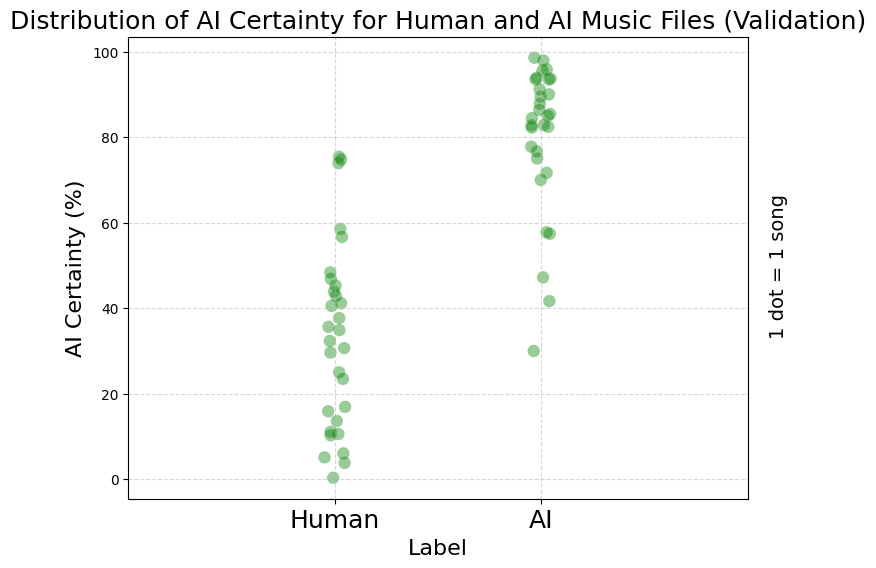

In [23]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Human'] * len(human_results) + ['AI'] * len(ai_results)
certainties = human_results + ai_results

base_x = {'Human': 0.4, 'AI': 0.6}
x_values = [base_x[label] for label in labels]

jitter_strength = 0.01
x_values_jittered = [x + np.random.uniform(-jitter_strength, jitter_strength) for x in x_values]

plt.figure(figsize=(8, 6))

plt.scatter(
    x_values_jittered, 
    certainties, 
    color='green', 
    alpha=0.4,         
    edgecolors='none', 
    s=80               
)

plt.xticks([0.4, 0.6], ['Human', 'AI'], fontsize=18)

plt.xlabel('Label', fontsize=16)
plt.ylabel('AI Certainty (%)', fontsize=16)
plt.title('Distribution of AI Certainty for Human and AI Music Files (Validation)', fontsize=18)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(0.2, 0.8)

# Move the annotation to the right side, just outside the plot
plt.text(0.82, 50, '1 dot = 1 song', rotation=90, fontsize=14, va='center', ha='left')

plt.show()


In [24]:
human_df = pd.DataFrame({
    'file_type': ['human'] * len(human_results),
    'ai_certainty_percentage': human_results
})

ai_df = pd.DataFrame({
    'file_type': ['ai'] * len(ai_results),
    'ai_certainty_percentage': ai_results
})

combined_df = pd.concat([human_df, ai_df], ignore_index=True)

from datetime import date
combined_df.to_csv(str(date.today()) + "_" + date.today().strftime("%b-%d-%Y") + '_data.csv', index=False)

print("Results have been saved")

Results have been saved


In [25]:
def evaluate_independent_file(file_path, model, classes=classes, 
                              SEGMENT_DURATION=SEGMENT_DURATION, HOP_LENGTH=HOP_LENGTH, 
                              PAD_LEN=PAD_LEN, debug=False):
    """
    Evaluates an independent audio file by converting it to mono 64kbps mp3, extracting MFCC features,
    and computing the AI certainty percentage using the provided model.
    
    Parameters:
    - file_path (str): Path to the input audio file.
    - model (keras.Model): Trained Keras model for prediction.
    - classes (list): List of class names (e.g., ["human", "ai"]).
    - SEGMENT_DURATION (float): Duration of each audio segment in seconds.
    - HOP_LENGTH (float): Hop length in seconds between segments.
    - PAD_LEN (int): Fixed length for MFCC padding/truncating.
    - debug (bool): If True, prints debug information.
    
    Returns:
    - certainty (float): AI certainty percentage for the file.
    """
    try:
        # create a temporary file for the converted mp3, probably not the best method but it works
        with tempfile.NamedTemporaryFile(suffix=".mp3", delete=False) as tmp:
            temp_mp3_path = tmp.name
        
        # Convert to mono 64kbps mp3 using ffmpeg
        ffmpeg_command = [
            "ffmpeg",
            "-i", file_path,
            "-ar", "22050",      # Sample rate
            "-ac", "1",          # Mono
            "-b:a", "64k",       # Bitrate
            "-y",                # Overwrite if exists
            temp_mp3_path
        ]
        
        subprocess.run(ffmpeg_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        
        audio, sample_rate = librosa.load(temp_mp3_path, sr=22050, mono=True)
        
        num_samples_per_segment = int(SEGMENT_DURATION * sample_rate)
        hop_length_samples = int(HOP_LENGTH * sample_rate)
        segments = []
        for start in range(0, len(audio) - num_samples_per_segment + 1, hop_length_samples):
            end = start + num_samples_per_segment
            segments.append(audio[start:end])
        
        # Extract features for each segment without normalization
        features = []
        for segment in segments:
            mfcc = extract_features(segment, sample_rate, PAD_LEN)
            if mfcc is not None:
                features.append(mfcc.astype(np.float32)[..., np.newaxis])  # Shape: (40, PAD_LEN, 1)
        
        if not features:
            print(f"No features extracted for '{file_path}'.")
            return 0.0
        
        features = np.array(features, dtype=np.float32)  # Shape: (num_segments, 40, PAD_LEN, 1)
        
        # predict classes for all segments in the file
        predictions = model.predict(features, batch_size=32, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)  # Shape: (num_segments,)
        
        ai_segments = np.sum(predicted_classes == 1)
        total_segments = len(predicted_classes)
        certainty = (ai_segments / total_segments) * 100 if total_segments > 0 else 0
        
        if debug:
            print(f"File: {file_path}, AI Certainty: {certainty:.2f}%")
        
        return certainty
    
    except subprocess.CalledProcessError:
        print(f"Error: ffmpeg failed to convert '{file_path}'.")
        return 0.0
    except Exception as e:
        print(f"Error processing '{file_path}': {e}")
        return 0.0
    finally:
        # Remove the temporary mp3 file
        if os.path.exists(temp_mp3_path):
            os.remove(temp_mp3_path)


In [26]:
evaluate_independent_file("content/audio/validation/human/dogsplusplus - Tree Songs 2 - 01 Welcome To The Woods_mono.mp3", model, debug=True)

File: content/audio/validation/human/dogsplusplus - Tree Songs 2 - 01 Welcome To The Woods_mono.mp3, AI Certainty: 31.63%


np.float64(31.63265306122449)

In [27]:
evaluate_independent_file("content/misc/pixelizer.mp3", model, debug=True)

File: content/misc/pixelizer.mp3, AI Certainty: 63.95%


np.float64(63.95348837209303)

In [28]:
evaluate_independent_file("content/audio/validation/human/LukHash - Virtual Burnout - 10 Shooting Star_mono.mp3", model, debug=True)

File: content/audio/validation/human/LukHash - Virtual Burnout - 10 Shooting Star_mono.mp3, AI Certainty: 27.72%


np.float64(27.717391304347828)

In [30]:
evaluate_independent_file("content/audio/validation/ai/3", model)

np.float64(41.66666666666667)